### Data Cleaning Notebook 1

***NOTE***: 

- Datsets Aquired from PolicyMap and the Health Resources and Services Administration (HRSA)


In [1]:
import pandas as pd

# Define file paths
files = {
    2018: "Data_Files_Uncleaned\Primary_Care_Physicians_2018.csv",
    2019: "Data_Files_Uncleaned\Primary_Care_Physicians_2019.csv",
    2020: "Data_Files_Uncleaned\Primary_Care_Physicians_2020.csv",
    2021: "Data_Files_Uncleaned\Primary_Care_Physicians_2021.csv"
}


In [2]:
# Create an empty list to store cleaned dataframes
dfs = []

for year, file in files.items():
    # Read CSV and skip the first metadata row
    df = pd.read_csv(file, header=1)
    
    # Select and rename the relevant columns
    df = df[["GeoID_Name", "SitsinState", "GeoID", "c_phys_ptncr_primcare"]].copy()
    df.columns = ["County", "State", "GeoID", f"Primary_Care_Physicians_{year}"]
    
    # Clean GeoID to ensure 5-digit FIPS format
    df["GeoID"] = df["GeoID"].astype(str).str.zfill(5)
    
    dfs.append(df)


In [3]:
# Merge all years
merged = dfs[0]
for df in dfs[1:]:
    merged = pd.merge(merged, df, on=["GeoID", "County", "State"], how="outer")

# Sort
merged = merged.sort_values(by=["State", "County"])

# Drop rows where all physician counts are zero
cols = ["Primary_Care_Physicians_2018", "Primary_Care_Physicians_2019",
        "Primary_Care_Physicians_2020", "Primary_Care_Physicians_2021"]

cleaned = merged[~(merged[cols].sum(axis=1) == 0)].copy()


***NOTE***: 

Some counties have 0.0 (num of primary care physicians) for every single year (2018-2021), this usually means either: 
- No data was reported (not necessarily zero doctors) 
- The location has too few providers for disclosure (which is common for HRSA data)


In [4]:
# Save output
cleaned.to_csv("primary_care_physicians_2018_2021.csv", index=False)

print("Cleaned dataset saved as 'primary_care_physicians_2018_2021.csv'")
print(cleaned.head())


Cleaned dataset saved as 'primary_care_physicians_2018_2021.csv'
            County State  GeoID  Primary_Care_Physicians_2018  \
68  Aleutians West    AK  02016                           2.0   
69       Anchorage    AK  02020                         367.0   
70          Bethel    AK  02050                          19.0   
72         Chugach    AK  02063                           NaN   
73    Copper River    AK  02066                           NaN   

    Primary_Care_Physicians_2019  Primary_Care_Physicians_2020  \
68                           2.0                           2.0   
69                         372.0                         374.0   
70                          20.0                          20.0   
72                           NaN                           0.0   
73                           NaN                           0.0   

    Primary_Care_Physicians_2021  
68                           3.0  
69                         373.0  
70                          16.0  
72     

***Data Analysis (validating data integrity)***: 

- Conducting Data Analysis below to determine if we gain meaningful insights from the data

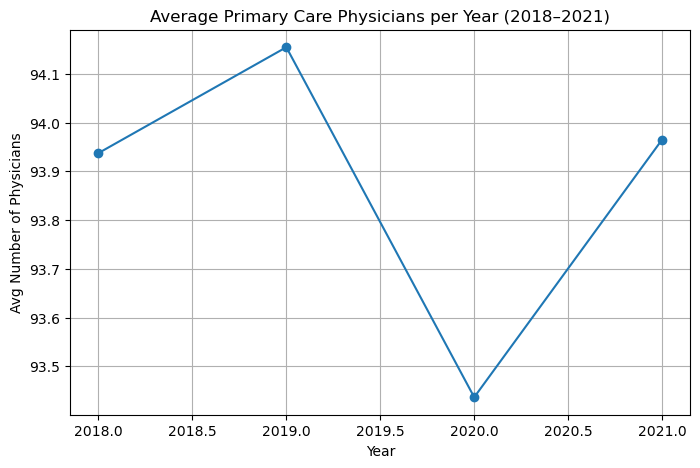

In [5]:
import matplotlib.pyplot as plt
import plotly.express as px

# Melt data for easy plotting
df_melted = cleaned.melt(
    id_vars=["State", "County"],
    value_vars=cols,
    var_name="Year",
    value_name="Primary_Care_Physicians"
)

# Clean year values to integers
df_melted["Year"] = df_melted["Year"].str.extract(r"(\d{4})").astype(int)

# --- Plot 1: Overall trend ---
plt.figure(figsize=(8, 5))
df_melted.groupby("Year")["Primary_Care_Physicians"].mean().plot(marker='o')
plt.title("Average Primary Care Physicians per Year (2018–2021)")
plt.xlabel("Year")
plt.ylabel("Avg Number of Physicians")
plt.grid(True)
plt.show()

# --- Plot 2: Per-state trend ---
# Calculate change from 2018 to 2021 per state
state_change = (
    cleaned.groupby("State")[["Primary_Care_Physicians_2018", "Primary_Care_Physicians_2021"]]
    .mean()
    .reset_index()
)

state_change["Change_2018_2021"] = (
    state_change["Primary_Care_Physicians_2021"] - state_change["Primary_Care_Physicians_2018"]
)
state_change.head()

fig = px.choropleth(
    state_change,
    locations="State",
    locationmode="USA-states",
    color="Change_2018_2021",
    color_continuous_scale="RdYlGn",
    scope="usa",
    title="Change in Primary Care Physicians by State (2018–2021)",
    labels={"Change_2018_2021": "Change in PCPs"},
)
fig.show()


***NOTE***: 

- Green = States where the average number of PCPs increased (improvement)
- Red = States with declines (possible data gaps or provider shortages)

County-Level mapping and analysis will be done in a PowerBI Dashboard, just demonstrating a short overall trend analysis with python. 
